In [1]:
#import libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#load data
train = pd.read_csv('../RawData/train.csv')
test = pd.read_csv('../RawData/test.csv')
sample_sub = pd.read_csv('../RawData/sample_solution.csv')

print(train.shape, test.shape)
train.head(10)

train.info()
train.isnull().sum()

(12243, 12) (3061, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12243 entries, 0 to 12242
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 12243 non-null  int64  
 1   gender             12243 non-null  object 
 2   age                12243 non-null  float64
 3   hypertension       12243 non-null  int64  
 4   heart_disease      12243 non-null  int64  
 5   ever_married       12243 non-null  object 
 6   work_type          12243 non-null  object 
 7   Residence_type     12243 non-null  object 
 8   avg_glucose_level  12243 non-null  float64
 9   bmi                12243 non-null  float64
 10  smoking_status     12243 non-null  object 
 11  stroke             12243 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.1+ MB


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [3]:
#pre-processing pipeline
#filling in missing values
train['bmi'].fillna(train['bmi'].median(), inplace=True)
test['bmi'].fillna(train['bmi'].median(), inplace=True)
train['smoking_status'].fillna('Unknown', inplace=True)
test['smoking_status'].fillna('Unknown', inplace=True)

#one-hot encoding the categorical variables
categorical_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
train_encoded = pd.get_dummies(train, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test, columns=categorical_cols, drop_first=True)

#preparing features and target variable
X = train_encoded.drop(['id', 'stroke'], axis=1, errors='ignore')
y = train_encoded['stroke']

#aligning test with train columns
X_test = test_encoded.drop('id', axis=1, errors='ignore')
X_test = X_test.reindex(columns=X.columns, fill_value=0)

#scaling numeric columns
num_cols = ['age', 'avg_glucose_level', 'bmi']
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("Preprocessing complete. Shapes -> X:", X.shape, "X_test:", X_test.shape)

Preprocessing complete. Shapes -> X: (12243, 16) X_test: (3061, 16)


/var/folders/_p/fft8jmnd11qfr0z1byyjlt1c0000gn/T/ipykernel_94590/3282217892.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train['bmi'].fillna(train['bmi'].median(), inplace=True)
/var/folders/_p/fft8jmnd11qfr0z1byyjlt1c0000gn/T/ipykernel_94590/3282217892.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting val

In [4]:
#saving preprocessed data
train_encoded.to_csv('../ProcessedData/train_encoded.csv', index=False)
X.to_csv('../ProcessedData/X_train_processed.csv', index=False)
X_test.to_csv('../ProcessedData/X_test_processed.csv', index=False)

Accuracy: 0.7839934667211107
Precision: 0.13851351351351351
Recall: 0.8118811881188119
F1 Score: 0.23665223665223664
ROC AUC: 0.8699630610420497


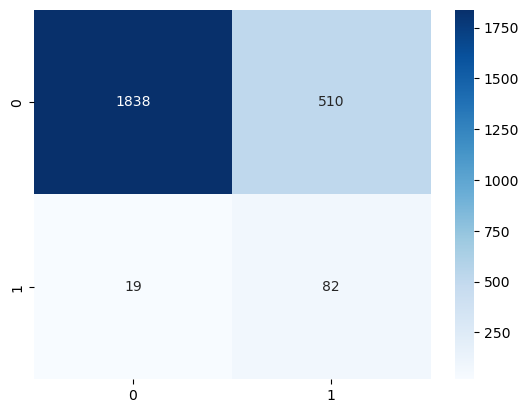

In [5]:
#splitting the data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#weight imbalance in stroke, making sure model does not just predict 0
lr = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

#predictions
y_pred = lr.predict(X_val)
y_proba = lr.predict_proba(X_val)[:,1]

#evaluation metrics
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))

#confusion matrix
sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt='d', cmap='Blues')
plt.show()

In [6]:
#test submission
test_preds = lr.predict(X_test)
submission = pd.DataFrame({'id': test['id'], 'stroke': test_preds})
submission.to_csv('../Output/submission.csv', index=False)
print("Submission file created: '../Output/submission.csv'")

Submission file created: '../Output/submission.csv'


In [7]:
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Precision:", precision_score(y_val, y_pred))
print("Recall:", recall_score(y_val, y_pred))
print("F1 Score:", f1_score(y_val, y_pred))
print("ROC AUC:", roc_auc_score(y_val, y_proba))

Accuracy: 0.7839934667211107
Precision: 0.13851351351351351
Recall: 0.8118811881188119
F1 Score: 0.23665223665223664
ROC AUC: 0.8699630610420497


In [8]:
submission = pd.read_csv('../Output/submission.csv')
submission['stroke'].value_counts()

stroke
0    2324
1     737
Name: count, dtype: int64